In [1]:
# For exploring the data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

# For splitting train and test data
from sklearn.model_selection import train_test_split

# For word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For text preprocessing
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# For model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
# Fetch Dataset
# The text file is provided in the following github location
# We are using pandas dataframe to read the data.
url = 'https://raw.githubusercontent.com/kenneth-lee-ch/SMS-Spam-Classification/master/spam.csv'
messages = pd.read_csv(url, encoding='ISO-8859-1')

# rename the columns
col_names = {
    'v1' : 'label',
    'v2' : 'message'
}
messages = messages[['v1', 'v2']]
messages.rename(columns=col_names, inplace=True)

# See the data
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
messages.describe()

WordCloud extracts most commply found words in the given text and removes meaniningless words and visualizes it in form of a plot.

In [3]:
# get all the ham and spam messages
ham_msg = messages[messages.label == 'ham']
spam_msg = messages[messages.label == 'spam']

# Create a list to visualize the words in wordCloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist()) 

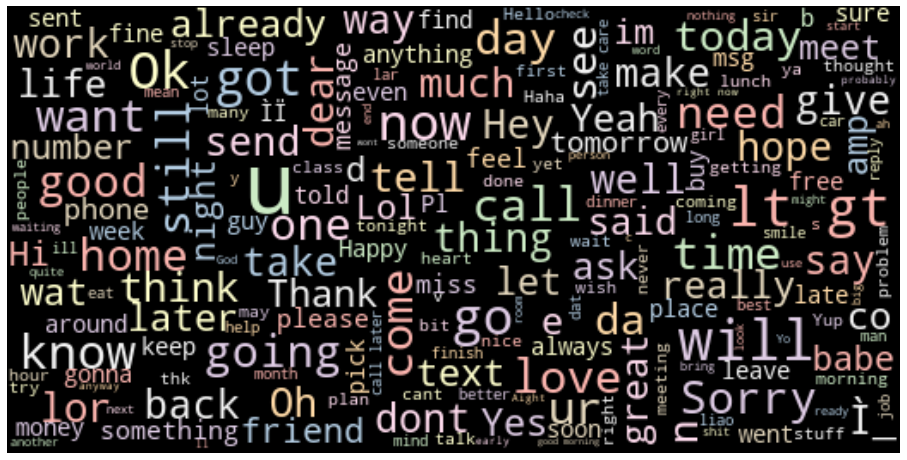

In [4]:
# WordCloud for ham messages
ham_msg_cloud = WordCloud(width=520, height=260,
                          stopwords=STOPWORDS, max_font_size=50,
                          background_color='black', colormap='Pastel1').generate(ham_msg_text)

plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

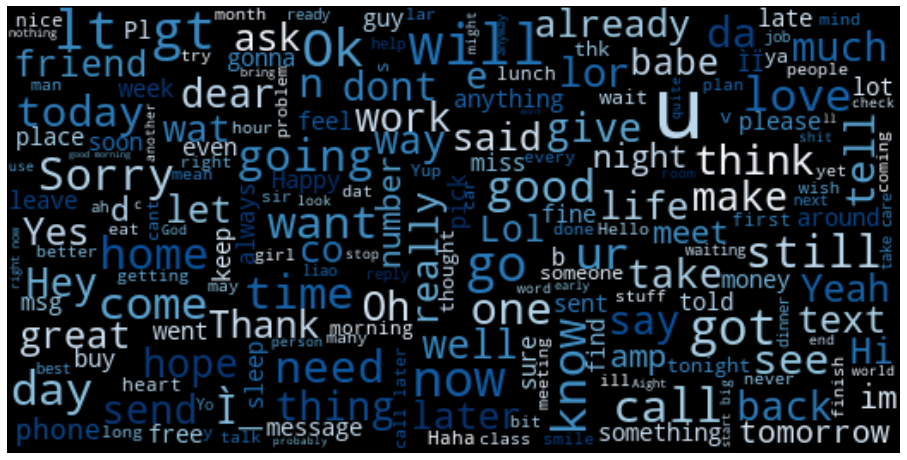

In [5]:
# WordCloud for spam messages
spam_msg_cloud = WordCloud(width=520, height=260,
                          stopwords=STOPWORDS, max_font_size=50,
                          background_color='black', colormap='Blues').generate(ham_msg_text)

plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'HAM and SPAM message distribution')

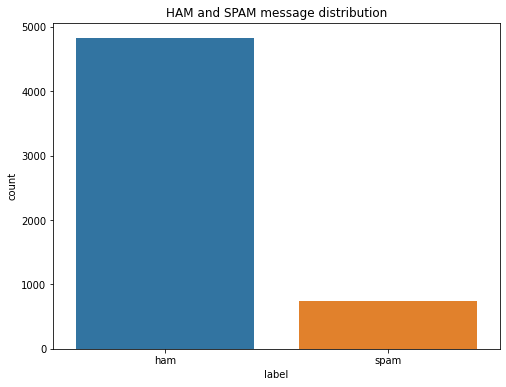

In [6]:
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
plt.title('HAM and SPAM message distribution')

In [7]:
# Percentage of sp am messages
(len(spam_msg)/len(messages))*100

13.406317300789663

This imbalance in the data needs to be handled and we can use upsampling/downsampling here. There are other ways to deal with such problems such as evaluation metrics and ensembling different datasets.

In [8]:
# Downsampling for handling unbalanced data
ham_msg_ = ham_msg.sample(n=len(spam_msg), random_state=44)
spam_msg_ = spam_msg

In [9]:
print(ham_msg_.shape, spam_msg_.shape)

(747, 2) (747, 2)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message Types')

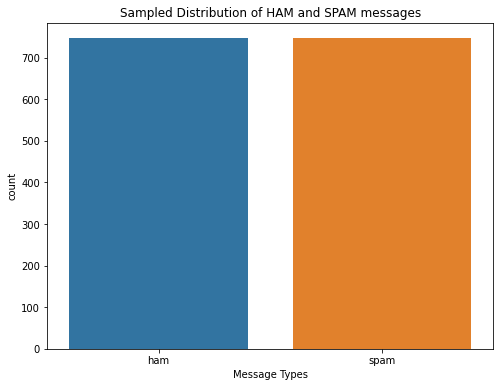

In [10]:
# Create a complete datafram containing sampled ham and spam msgs
messages_ = ham_msg_.append(spam_msg_).reset_index(drop=True)

# Plot the distribution
plt.figure(figsize=(8,6))
sns.countplot(messages_.label)
plt.title('Sampled Distribution of HAM and SPAM messages')
plt.xlabel('Message Types')

Preparing the train and test data and pre-processing text
Splitting data into training set and testing set and convering the label to numpy array to fit the depp learning models.

In [11]:
# Preprocessing the train and test dataset
messages_['msg_type'] = messages_['label'].map({'ham':0, 'spam':1})
msg_label = messages_['msg_type'].values

# Split the main data into training and test data
train_msg, test_msg, train_labels, test_labels = train_test_split(messages_['message'], msg_label, test_size=0.2, random_state=434)

As deep learning models do not understand text, we need to convert the text into numerical representation.
Text pre-processing includes:
- Tokenisation: encoding words into integers
- Sequencing: representing sentences by sequences of numbers
- Padding: To have same length of each text of every iteration

In [12]:
# Preprocessing hyperparameters
vocab_size = 10000
max_len = 100 # Fix the length of messages
padding_type = 'post'
trunc_type = 'post'
oov_tok = ""
class_names = ['HAM', 'SPAM']

In [13]:
# Concatenate test and training reviews
allreviews = np.concatenate((train_msg, test_msg), axis=0)

# Converting text into numerical representation: Tokenisation
tokeniser = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)
tokeniser.fit_on_texts(allreviews)
tokeniser.fit_on_texts(train_msg)

# Get the word indices
word_index = tokeniser.word_index

# Ensure the 'special' words are mapped into human readable terms
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"]     = 0
word_index["<START>"]   = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"]  = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_messages(text):
    return " ".join([reverse_word_index.get(i, '?') for i in text])

In [14]:
total_words = len(word_index)
print('%s unique tokens in the training data. ' %total_words)

4628 unique tokens in the training data. 


In [15]:
# Data Insights
# Review lengths accross test and training messages
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset.
print("")
print("Human Readable Messages")
print("  Message Text: " + str(train_msg[20]))
print("  Message Type: " + str(train_labels[20]))

Maximum review length: 482
Minimum review length: 3
Mean review length: 104.2463186077644

Human Readable Messages
  Message Text: Orh i tot u say she now still dun believe.
  Message Type: 1


In [16]:
# Sequencing and Padding/Truncate the messages
training_seq = tokeniser.texts_to_sequences(train_msg)
train_padded = pad_sequences(training_seq, maxlen=max_len,
                             padding=padding_type, truncating=trunc_type)
testing_seq = tokeniser.texts_to_sequences(test_msg)
test_padded = pad_sequences(testing_seq, maxlen=max_len,
                            padding=padding_type, truncating=trunc_type)


print("Shape Training Review Data: " + str(train_padded.shape))
print("Shape Training Class Data: " + str(train_labels.shape))
print("Shape Test Review Data: " + str(test_padded.shape))
print("Shape Test Class Data: " + str(test_labels.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + str(train_msg[20]))

Shape Training Review Data: (1195, 100)
Shape Training Class Data: (1195,)
Shape Test Review Data: (299, 100)
Shape Test Class Data: (299,)

Human Readable Review Text (post padding): Orh i tot u say she now still dun believe.


In [17]:
# Build an LSTM Network
model = Sequential()

# We need an Embedding Layer, which provides Word Embedding of all the 
# individual words in out training set. (Word close to each other do share
# context or meaninig)
model.add(Embedding(input_dim = vocab_size,
                    output_dim=32,
                    input_length = max_len))
# Add LSTM Layer
model.add(LSTM(units=20, # 20 LSTM units in the layer
               dropout=0.2, return_sequences=True))
# Add 2nd LSTM Layer
model.add(LSTM(units=20, # 20 LSTM units in the layer
               dropout=0.2, return_sequences=True))
# Add Dense Layer with a sigmoid activation
model.add(Dense(units=1,
                activation='sigmoid'))  # output from 0 to 1

# Compile the model
model.compile(
    loss=binary_crossentropy,
    optimizer=Adam(),
    metrics=['accuracy'])

# See the model summary
model.summary()

2023-01-09 22:02:19.493236: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 100, 20)           4240      
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 20)           3280      
_________________________________________________________________
dense (Dense)                (None, 100, 1)            21        
Total params: 327,541
Trainable params: 327,541
Non-trainable params: 0
_________________________________________________________________


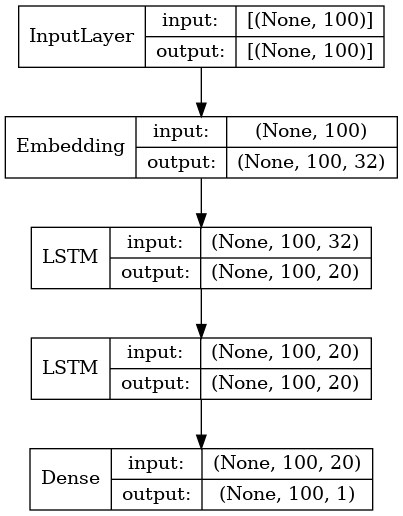

In [18]:
plot_model(model, to_file='model.png', 
           show_shapes=True, show_layer_names=False)

In [19]:
# Training the LSTM
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_padded, train_labels, epochs=30,
                    validation_data=(test_padded, test_labels),
                    callbacks=[early_stop], verbose=2)

2023-01-09 22:02:21.384016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
38/38 - 10s - loss: 0.6896 - accuracy: 0.5446 - val_loss: 0.6697 - val_accuracy: 0.6143
Epoch 2/30
38/38 - 4s - loss: 0.3941 - accuracy: 0.8356 - val_loss: 0.1729 - val_accuracy: 0.9628
Epoch 3/30
38/38 - 4s - loss: 0.1594 - accuracy: 0.9605 - val_loss: 0.1267 - val_accuracy: 0.9713
Epoch 4/30
38/38 - 4s - loss: 0.1079 - accuracy: 0.9770 - val_loss: 0.1706 - val_accuracy: 0.9589
Epoch 5/30
38/38 - 4s - loss: 0.0696 - accuracy: 0.9867 - val_loss: 0.1141 - val_accuracy: 0.9710
Epoch 6/30
38/38 - 4s - loss: 0.0545 - accuracy: 0.9894 - val_loss: 0.1770 - val_accuracy: 0.9589
Epoch 7/30
38/38 - 4s - loss: 0.0526 - accuracy: 0.9900 - val_loss: 0.1798 - val_accuracy: 0.9582
Epoch 8/30
38/38 - 4s - loss: 0.0299 - accuracy: 0.9937 - val_loss: 0.1869 - val_accuracy: 0.9592


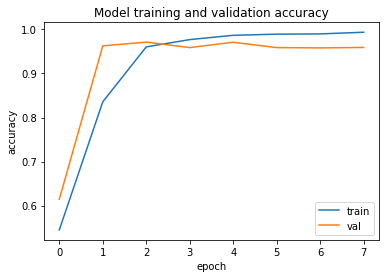

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

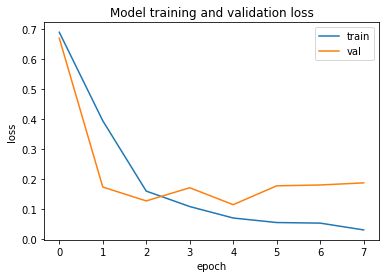

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [22]:
# Finding out the model's performance on the test dataset
print(f"LSTM loss and accuracy:{model.evaluate(test_padded, test_labels)} ")

10/10 [==============================] - 0s 20ms/step - loss: 0.1869 - accuracy: 0.9592
LSTM loss and accuracy:[0.18685108423233032, 0.9591972827911377] 
